In [71]:
import numpy as np
from matplotlib import pyplot as plt
import os

# Ensure figs directory exists
os.makedirs("figs", exist_ok=True)

plt.rcParams.update({
    "figure.figsize": (8, 6),
    "figure.dpi": 200,
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "lines.linewidth": 2,
})


In [11]:
# Problem 1

a = 1.0
b = 3.0
delta = 1e-10
t_final = 20.0
H_init = 20.0
n_seq = [2, 4, 6, 8]

def f(t, y):
    x, yy = y
    # avoid overflow by clamping intermediate values
    if abs(x) > 1e6 or abs(yy) > 1e6:
        return np.zeros(2)
    dx = 1.0 - (b + 1.0) * x + a * x * x * yy
    dy = b * x - a * x * x * yy
    if np.any(np.isnan([dx, dy])) or np.any(np.isinf([dx, dy])):
        return np.zeros(2)
    return np.array([dx, dy])

def modified_midpoint(y0, t0, H, n):
    h = H / n
    y_nm2 = y0.copy()
    y_nm1 = y0 + h * f(t0, y0)
    if n == 1:
        return y_nm1
    t = t0 + h
    for _ in range(2, n+1):
        fi = f(t, y_nm1)
        if np.any(np.isnan(fi)) or np.any(np.isinf(fi)):
            return y_nm1
        y_i = y_nm2 + 2.0 * h * fi
        y_nm2, y_nm1 = y_nm1, y_i
        t += h
    return y_nm1


In [12]:
def extrapolate_with_history(Y, x):
    m = len(Y)
    table = [[None]*m for _ in range(m)]
    for i in range(m):
        table[i][0] = Y[i].copy()
    for j in range(1, m):
        for i in range(m - j):
            xi, xj = x[i], x[i+j]
            Ai, Aj = table[i][j-1], table[i+1][j-1]
            table[i][j] = ((-xj) * Ai + xi * Aj) / (xi - xj)
    return [table[0][j] for j in range(m)]

def bulirsch_stoer_step(y, t, H, delta, n_seq):
    endpoints, hsquared = [], []
    for n in n_seq:
        Yn = modified_midpoint(y, t, H, n)
        endpoints.append(Yn)
        h = H / n
        hsquared.append(h*h)
        diag = extrapolate_with_history(endpoints, hsquared)
        if len(diag) >= 2:
            y_extrap, y_prev = diag[-1], diag[-2]
            tol = delta * H
            err_vec = np.abs(y_extrap - y_prev)
            scale = np.maximum(1.0, np.abs(y_extrap))
            err_scaled = err_vec / (tol * scale)
            err = np.max(err_scaled)
            if err <= 1.0:
                return True, y_extrap, err, n
    return False, None, None, None

def integrate():
    t, y = 0.0, np.array([0.0, 0.0])
    H = H_init
    ts, ys, boundaries_t = [t], [y.copy()], [t]
    step_count = 0
    while t < t_final - 1e-14:
        if t + H > t_final:
            H = t_final - t
        accepted = False
        while not accepted:
            ok, y_new, err, used_n = bulirsch_stoer_step(y, t, H, delta, n_seq)
            step_count += 1
            if ok:
                t += H
                y = y_new.copy()
                ts.append(t)
                ys.append(y.copy())
                boundaries_t.append(t)
                order = 2 * (used_n // 2)
                safety = 0.9
                fac = 4.0 if err == 0 else safety * (1.0/err)**(1.0/(order+1))
                fac = np.clip(fac, 0.5, 4.0)
                H_new = H * fac
                H = H_new
                accepted = True
            else:
                H /= 2.0
                if H < 1e-16:
                    raise RuntimeError("Step size underflow.")
    return np.array(ts), np.array(ys), boundaries_t

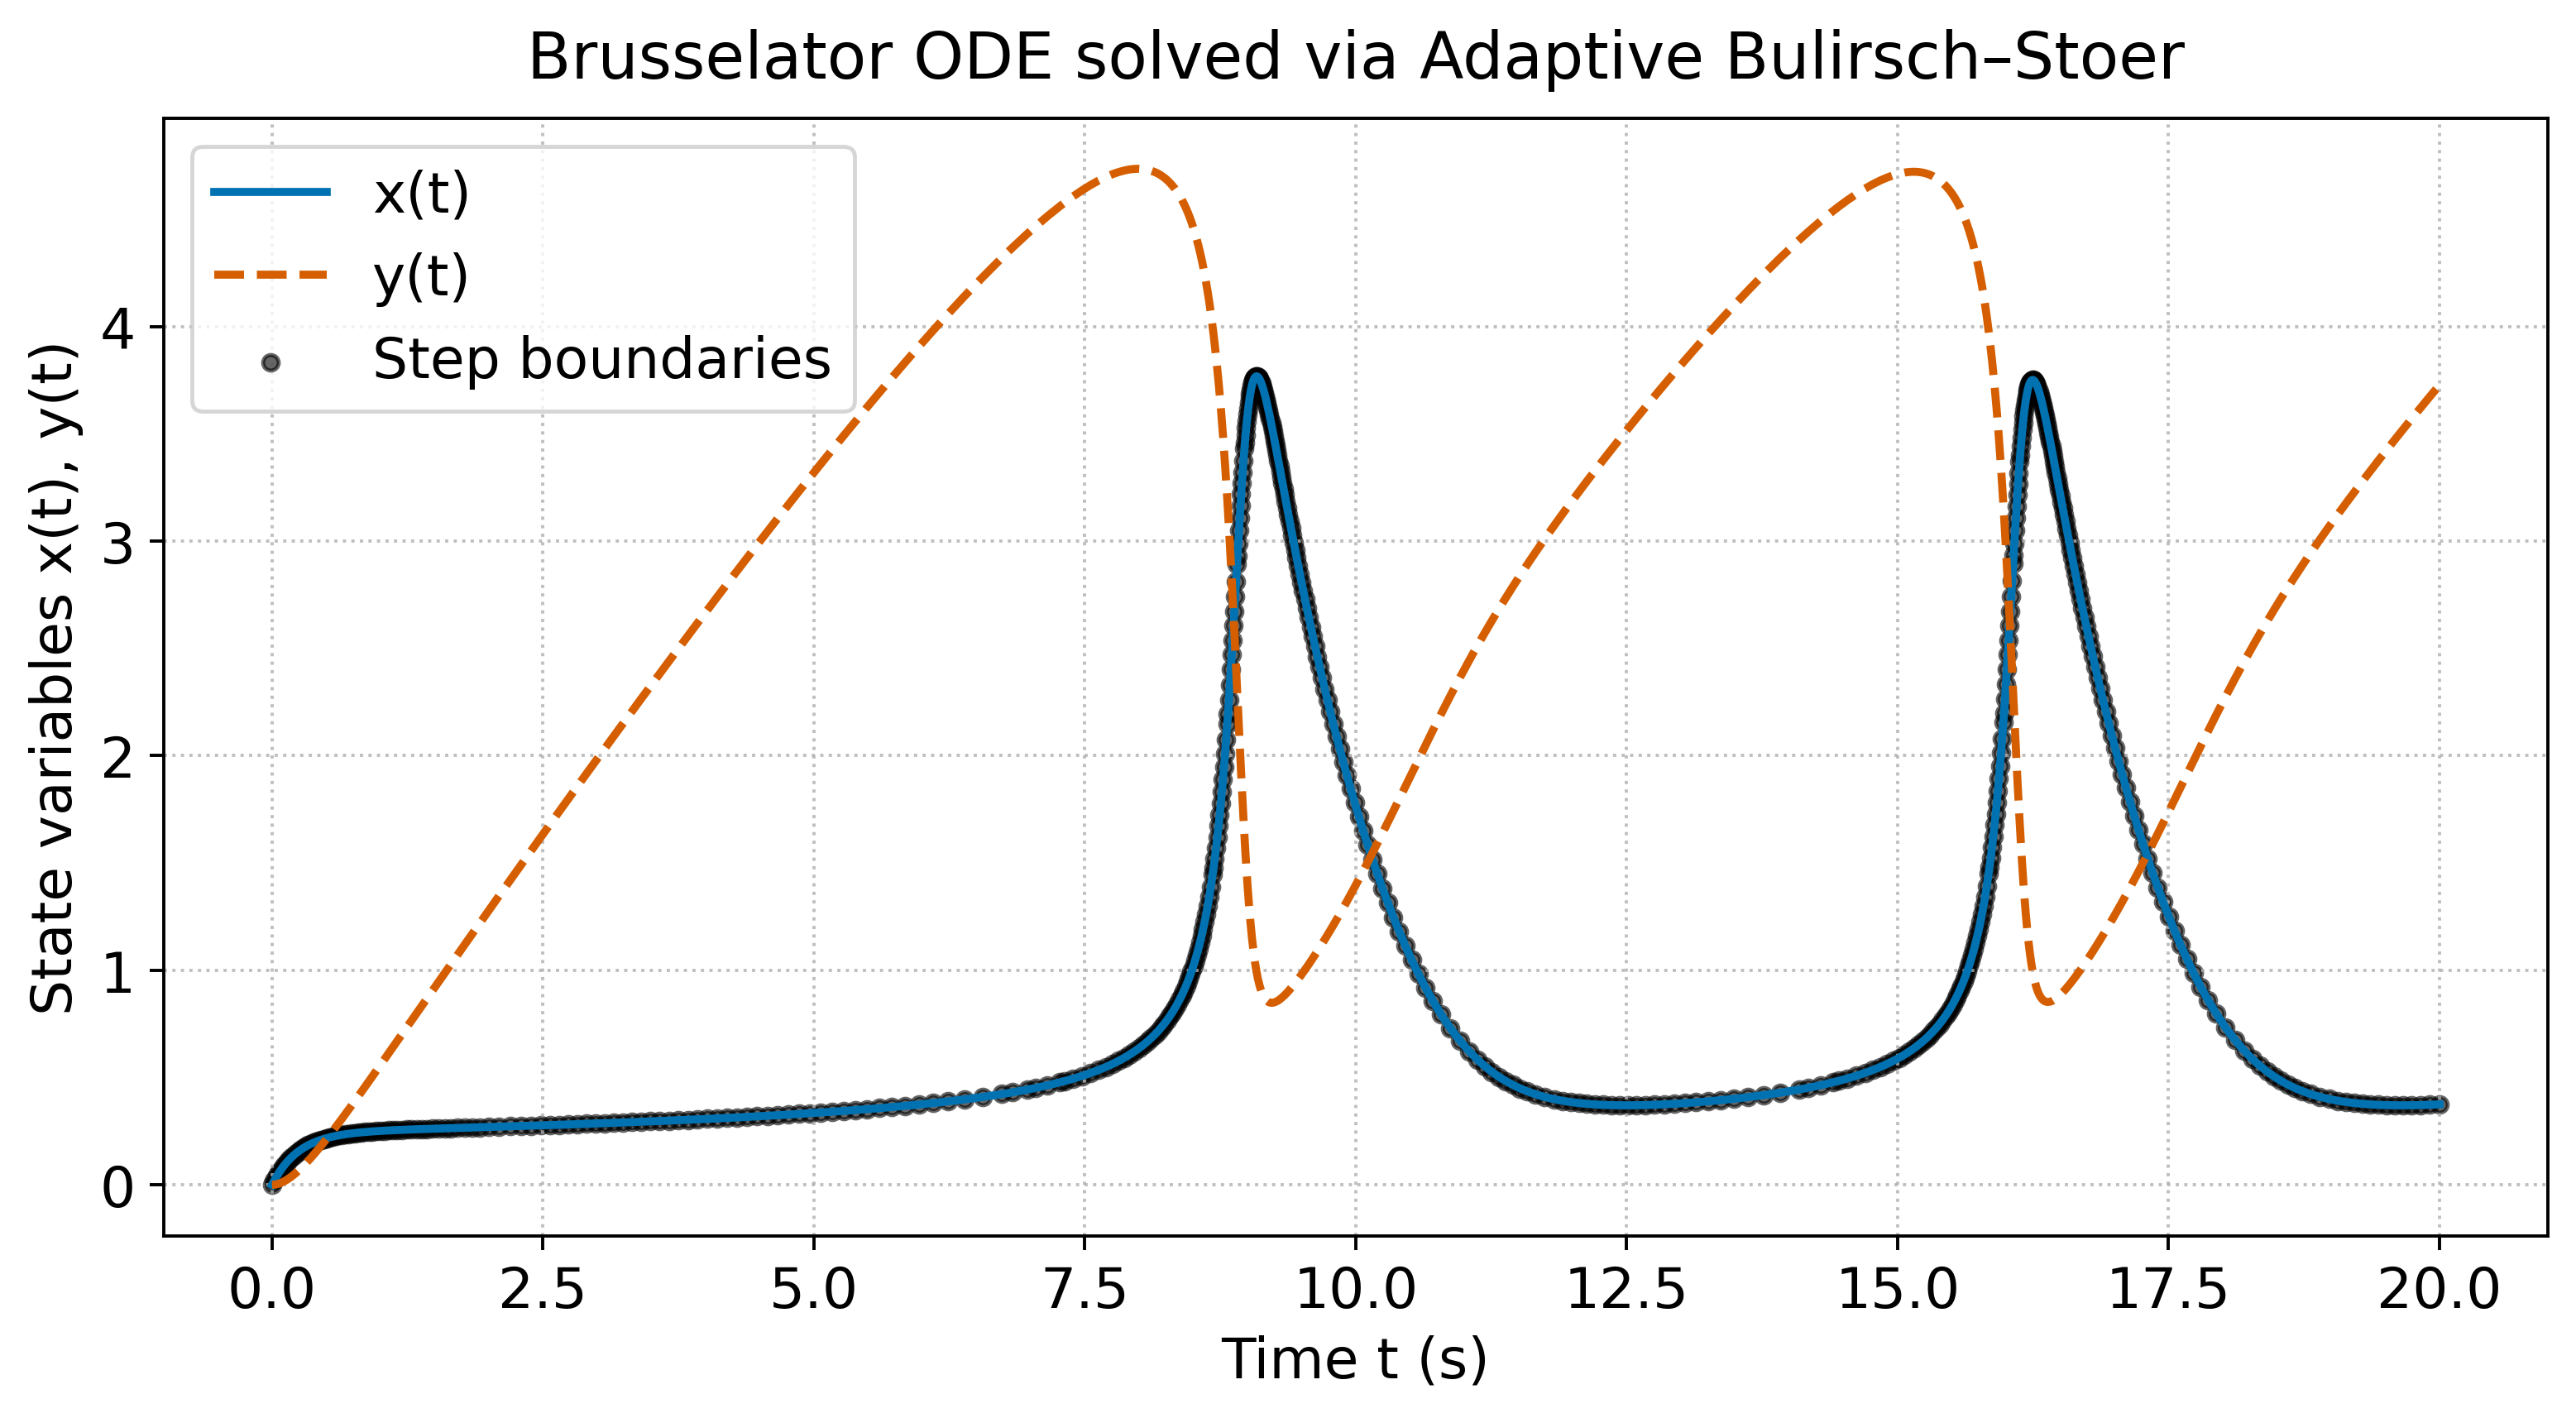

In [18]:
ts, ys, boundaries = integrate()
x_vals, y_vals = ys[:,0], ys[:,1]

fig, ax = plt.subplots(figsize=(9, 5), dpi=350)
ax.plot(ts, x_vals, color="#0072B2", linewidth=2, label="x(t)")
ax.plot(ts, y_vals, color="#D55E00", linewidth=2, linestyle="--", label="y(t)")
ax.scatter(boundaries, np.interp(boundaries, ts, x_vals), s=15, color="k", alpha=0.6, label="Step boundaries")

ax.set_title("Brusselator ODE solved via Adaptive Bulirsch–Stoer", fontsize=16, pad=10)
ax.set_xlabel("Time t (s)", fontsize=14)
ax.set_ylabel("State variables x(t), y(t)", fontsize=14)
ax.legend(frameon=True, loc="best",fontsize=14)
ax.grid(True, which="both", linestyle=":", linewidth=0.8, alpha=0.8)
ax.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig("figs/brusselator.png")

In [52]:
# Cell 1: imports and global parameters
from math import sqrt
from scipy import optimize

plt.style.use("seaborn-v0_8-darkgrid")

# Physical / unit choices
G = 1.0
M = 1.0
r_schw = 1e-7         # Schwarzschild radius (internal units)
R_unit_pc = 100.0     # distance unit in parsec 
M_phys_Msun_default = 1e8

In [53]:

def acceleration_cartesian(pos, vel, A=0.0, B=0.0):
    x, y = pos
    vx, vy = vel
    r = np.hypot(x, y)
    if r == 0.0:
        return np.array([0.0, 0.0])
    a_grav = -G * M * np.array([x, y]) / (r**3)
    v = np.hypot(vx, vy)
    if v == 0.0:
        a_df = np.array([0.0, 0.0])
    else:
        denom = v**3 + B
        if denom <= 0 or not np.isfinite(denom):
            a_df = np.array([0.0, 0.0])
        else:
            a_df = - (A / denom) * np.array([vx, vy])
    return a_grav + a_df

def deriv_from_state(y_vec, A=0.0, B=0.0):
    # y_vec = [x, y, vx, vy]
    x, y, vx, vy = y_vec
    a = acceleration_cartesian(np.array([x, y]), np.array([vx, vy]), A=A, B=B)
    return np.array([vx, vy, a[0], a[1]], dtype=float)

def rk4_step_state(y, t, h, deriv_func, A=0.0, B=0.0):
    k1 = deriv_func(y, A=A, B=B)
    k2 = deriv_func(y + 0.5*h*k1, A=A, B=B)
    k3 = deriv_func(y + 0.5*h*k2, A=A, B=B)
    k4 = deriv_func(y + h*k3, A=A, B=B)
    return y + (h/6.0) * (k1 + 2*k2 + 2*k3 + k4)

def adaptive_rk4_step(y, t, h, deriv_func, tol_per_unit_time, A=0.0, B=0.0):
    # one big step
    y_big = rk4_step_state(y, t, h, deriv_func, A=A, B=B)
    # two half steps
    y_half_1 = rk4_step_state(y, t, h/2.0, deriv_func, A=A, B=B)
    y_two = rk4_step_state(y_half_1, t + h/2.0, h/2.0, deriv_func, A=A, B=B)
    # estimate error (RK4 step-doubling factor)
    err_vec = (y_two - y_big) / 15.0
    tol_vec = tol_per_unit_time * h * np.maximum(1.0, np.abs(y_two))
    tol_vec = np.maximum(tol_vec, 1e-16)
    err_scaled = np.abs(err_vec) / tol_vec
    err_norm = np.max(err_scaled)
    if not np.isfinite(err_norm):
        return False, None, h/2.0, np.inf
    if err_norm <= 1.0:
        # suggest new h
        safety = 0.9
        order = 4
        if err_norm == 0:
            fac = 2.0
        else:
            fac = safety * (1.0/err_norm)**(1.0/(order+1))
        fac = np.clip(fac, 0.5, 2.0)
        return True, y_two, h * fac, err_norm
    else:
        safety = 0.9
        order = 4
        fac = safety * (1.0/err_norm)**(1.0/(order+1))
        fac = np.clip(fac, 0.1, 0.5)
        return False, None, h * fac, err_norm


In [54]:

def integrate_orbit(y0, t0=0.0, h_init=1e-3, t_final=100.0, delta=1e-6,
                    A=0.0, B=0.0, r_stop=r_schw, max_steps=int(2e5),
                    print_steps=False, stop_after_orbits=None):
    t = t0
    y = y0.astype(float).copy()
    h = h_init
    ts = [t]
    ys = [y.copy()]

    # track angle to count orbits
    phi0 = np.arctan2(y[1], y[0])
    orbits_done = 0.0

    for step in range(int(max_steps)):
        r_now = np.hypot(y[0], y[1])
        if r_now <= r_stop:
            if print_steps:
                print(f"Reached r_stop at t={t:.6e}, r={r_now:.3e}")
            break
        if t >= t_final:
            if print_steps:
                print(f"Reached t_final at t={t:.6e}")
            break

        accepted, y_next, h_new, err = adaptive_rk4_step(y, t, h, deriv_from_state, delta, A=A, B=B)
        if accepted:
            t += h
            y = y_next.copy()
            ts.append(t)
            ys.append(y.copy())

            # count orbits if requested
            if stop_after_orbits is not None:
                phi = np.arctan2(y[1], y[0])
                dphi = (phi - phi0)
                # normalize to positive progression
                dphi = (dphi + 10*np.pi) % (2*np.pi)
                orbits_done = dphi / (2*np.pi)
                if orbits_done >= stop_after_orbits:
                    if print_steps:
                        print(f"Completed {orbits_done:.3f} orbits at t={t:.6e}")
                    break

            if print_steps and (step % 500 == 0 or err > 0.5):
                print(f"step {step:6d}: t={t:.6e}, h={h:.3e}, err={err:.2e}, r={r_now:.3e}")

            h = min(h_new, t_final - t)
        else:
            # rejected: shrink and retry
            if print_steps:
                print(f"step {step:6d} REJECT at t={t:.6e}, err={err:.2e}, h->{h_new:.3e}")
            h = max(h_new, 1e-16)
            if h < 1e-16:
                if print_steps:
                    print("Step size underflow; stopping.")
                break

    return np.array(ts), np.array(ys)


In [55]:
# plotting helper (not used)
def plot_bh_orbit(ts, ys, title="BH orbit (A,B)", show_schwarz=True, r_s=r_schw, dpi=160):
    x = ys[:,0]
    y = ys[:,1]
    r = np.hypot(x, y)

    fig, axes = plt.subplots(1,2, figsize=(11,4), dpi=dpi)
    ax0, ax1 = axes

    # orbit panel
    ax0.plot(x, y, color="#2b2b2b", lw=1.1)
    if show_schwarz:
        circ = plt.Circle((0,0), r_s, color='k', alpha=0.6)
        ax0.add_patch(circ)
    lim = max(np.max(np.abs(x)), np.max(np.abs(y))) * 1.1
    lim = max(lim, 1.2)
    ax0.set_xlim(-lim, lim)
    ax0.set_ylim(-lim, lim)
    ax0.set_aspect('equal', 'box')
    ax0.set_xlabel("x (code units)")
    ax0.set_ylabel("y (code units)")
    ax0.set_title("Trajectory (Cartesian)")

    # radius vs time panel
    ax1.plot(ts, np.log10(r), color="#c0392b", lw=1.2)
    ax1.set_xlabel("Time (internal units)")
    ax1.set_ylabel(r"$\log_{10} r$")
    ax1.set_title("Radius decay")
    ax1.grid(True, ls=":", alpha=0.6)

    plt.suptitle(title, fontsize=13)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()


In [56]:
#kepler utility for part a
def compute_pericenter_from_v(v0, r0=1.0):
    E = 0.5 * v0**2 - G*M / r0
    h = r0 * v0
    arg = 1.0 + 2.0 * E * h**2 / (G**2 * M**2)
    if arg < 0:
        e = 0.0
    else:
        e = np.sqrt(arg)
    r_p = h**2 / (G*M * (1.0 + e))
    return r_p, e

def find_v_for_pericenter(rp_target, v_min=1e-6, v_max=1.4, tol=1e-12):
    def f(v):
        rp, _ = compute_pericenter_from_v(v)
        return rp - rp_target
    # bracket and bisect
    a, b = v_min, v_max
    fa, fb = f(a), f(b)
    if fa * fb > 0:
        vs = np.linspace(v_min, v_max, 400)
        vals = [f(v) for v in vs]
        idx = next((i for i in range(len(vals)-1) if vals[i]*vals[i+1] <= 0), None)
        if idx is None:
            raise RuntimeError("Could not bracket pericenter")
        a, b = vs[idx], vs[idx+1]
    return optimize.bisect(f, a, b, xtol=tol)


In [ ]:

def part_a_set_delta_and_test(delta_try=1e-6, n_orbits=10, show_plot=True):
    rp_target = r_schw
    v0 = find_v_for_pericenter(rp_target)
    print(f"Found v0 = {v0:.8e} for r_peri = {rp_target:.1e}")

    y0 = np.array([1.0, 0.0, 0.0, v0])
    P = 2 * np.pi  # estimated period for r=1 (G=M=1)
    t_final = n_orbits * P

    ts, ys = integrate_orbit(
        y0, t0=0.0, h_init=1e-4, t_final=t_final,
        delta=delta_try, A=0.0, B=0.0, r_stop=r_schw,
        print_steps=False
    )

    if show_plot:
        # Extract coordinates
        x = ys[:, 0]
        y = ys[:, 1]
        r = np.sqrt(x**2 + y**2)

        # orbit plot
        fig, ax = plt.subplots()
        ax.plot(x, y, color="darkblue")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_title(f"Part (a): BH Orbit (no DF), v0={v0:.6e}")
        ax.axis("equal")
        
        #zoom in
        x_range = x.max() - x.min()
        y_range = y.max() - y.min()
        ax.set_xlim(x.min() - 0.1*x_range, x.max() + 0.1*x_range)
        ax.set_ylim(y.min() - 0.1*y_range, y.max() + 0.1*y_range)
        
        plt.tight_layout()
        plt.savefig("figs/part_a_orbit_cartesian.png")
        plt.close(fig)

        # --- Radius vs time ---
        fig, ax = plt.subplots()
        ax.plot(ts, r, color="darkred")
        ax.set_xlabel("Time (t)")
        ax.set_ylabel("r(t)")
        ax.set_title("Part (a): Radius vs Time")
        plt.tight_layout()
        plt.savefig("figs/part_a_radius_vs_time.png")
        plt.close(fig)

    return ts, ys, v0


# Quick run
ts_a, ys_a, v0 = part_a_set_delta_and_test(delta_try=1e-6, n_orbits=1000)


In [ ]:

def part_b_orbit_with_AB(A=1.0, B=1.0, v_frac_of_circ=0.8, delta=1e-6, n_orbits=10):
    r0 = 1.0
    v_circ = np.sqrt(1 / (4 * r0))  # circular velocity for G=M=1, r=1
    v0 = v_frac_of_circ * v_circ
    y0 = np.array([r0, 0.0, 0.0, v0])

    P_est = 2 * np.pi
    t_final = n_orbits * P_est

    ts, ys = integrate_orbit(
        y0, t0=0.0, h_init=1e-4, t_final=t_final,
        delta=delta, A=A, B=B, r_stop=r_schw, print_steps=False
    )
    return ts, ys, v0


# === Run Part (b) ===
A = 1.0
B = 1.0
v_frac_of_circ = 0.8
ts_b, ys_b, v0_b = part_b_orbit_with_AB(A=A, B=B, v_frac_of_circ=v_frac_of_circ)

print(f"A={A}, B={B}, v_frac_of_circ={v_frac_of_circ}, v0={v0_b:.3e}")
print(f"t range: {ts_b[0]:.3e} → {ts_b[-1]:.3e}, (#points: {len(ts_b)})")
r_b = np.sqrt(ys_b[:,0]**2 + ys_b[:,1]**2)
print(f"r range: {r_b.min():.3e} → {r_b.max():.3e}")

# radius decay vs time
plt.figure(figsize=(8,6), dpi=150)
plt.plot(ts_b, r_b, lw=2)
plt.xlabel("Time", fontsize=14)
plt.ylabel("r", fontsize=14)
plt.title(f"Part (b): Radius Decay (A={A}, B={B}, v0={v0_b:.3e})", fontsize=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("figs/part_b_radius_decay.png", dpi=300)
plt.close()

#trajectory
x_b, y_b = ys_b[:,0], ys_b[:,1]
plt.figure(figsize=(7,7), dpi=200)
plt.plot(x_b, y_b, lw=2, color="darkred")

plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.title(f"Part (b): BH Orbit (A={A}, B={B})", fontsize=15)
plt.axis("equal")
plt.grid(True, alpha=0.3)

x_range = x_b.max() - x_b.min()
y_range = y_b.max() - y_b.min()
plt.xlim(x_b.min() - 0.1*x_range, x_b.max() + 0.1*x_range)
plt.ylim(y_b.min() - 0.1*y_range, y_b.max() + 0.1*y_range)

plt.tight_layout()
plt.savefig("figs/part_b_orbit_cartesian.png", dpi=300)
plt.close()


In [ ]:
def part_c_time_to_schwarzschild_vs_ratio(
        A_vals=None, B_vals=None, v_frac=0.8, delta=1e-6,
        M_phys_Msun=M_phys_Msun_default, t_final=1e5,
        savepath="figs/part_c_time_vs_ratio.png"):
    if A_vals is None:
        A_vals = np.logspace(-1, 1, 6)  # 0.1–10
    if B_vals is None:
        B_vals = np.logspace(-1, 1, 6)
    ratio_list, time_list_myr = [], []
    v_circ = np.sqrt(G*M / 1.0)
    for A in A_vals:
        for B in B_vals:
            y0 = np.array([1.0, 0.0, 0.0, v_frac * v_circ])
            ts, ys = integrate_orbit(
                y0, t0=0.0, h_init=1e-3, t_final=t_final,
                delta=delta, A=A, B=B, r_stop=r_schw, print_steps=False)
            t_reach = ts[-1] if len(ts) > 0 else np.nan
            ratio_list.append(B/A if A != 0 else np.nan)
            t_myr = convert_time_to_myr(np.array([t_reach]), M_phys_Msun=M_phys_Msun)[0]
            time_list_myr.append(t_myr)

    ratio_arr = np.array(ratio_list)
    t_arr = np.array(time_list_myr)

    fig, ax = plt.subplots(figsize=(8,6), dpi=250)
    sc = ax.scatter(ratio_arr, t_arr, c=np.log10(t_arr), cmap="viridis", s=60, edgecolor='k')
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel("B/A", fontsize=14)
    ax.set_ylabel("Time to reach $r_s$ (Myr)", fontsize=14)
    ax.set_title("Part (c): Inspiral time vs. drag ratio B/A", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label("log10(Time [Myr])", fontsize=13)
    ax.grid(True, ls=":", alpha=0.6)
    plt.tight_layout()
    plt.savefig(savepath, dpi=300)
    plt.close(fig)
    print(f"Saved figure to {savepath}")
    return ratio_arr, t_arr

# ---- Run part (c)
ratio_arr, t_arr = part_c_time_to_schwarzschild_vs_ratio(
    A_vals=np.logspace(-1, 1, 5),
    B_vals=np.logspace(-1, 1, 5),
    v_frac=0.8,
    delta=1e-6,
    t_final=5e3,
    savepath="figs/part_c_time_vs_ratio.png"
)

In [ ]:
def part_d_dependence_on_initial_velocity(
        A=1.0, B=1.0, v_fracs=None, delta=1e-6, t_final=1e5,
        savepath="figs/part_d_time_vs_vfrac.png"):
    if v_fracs is None:
        v_fracs = np.linspace(0.6, 0.95, 8)
    v_circ = np.sqrt(G*M / 1.0)
    times = []
    for vf in v_fracs:
        y0 = np.array([1.0, 0.0, 0.0, vf * v_circ])
        ts, ys = integrate_orbit(
            y0, t0=0.0, h_init=1e-3, t_final=t_final,
            delta=delta, A=A, B=B, r_stop=r_schw, print_steps=False)
        t_reach = ts[-1] if len(ts) > 0 else np.nan
        times.append(t_reach)
        print(f"v_frac = {vf:.2f} → t_reach = {t_reach:.4e}")

    v_fracs = np.array(v_fracs)
    times = np.array(times)
    t_myr = convert_time_to_myr(times)

    fig, ax = plt.subplots(figsize=(8,6), dpi=250)
    ax.plot(v_fracs, t_myr, 'o-', color='darkred', lw=2, markersize=6)
    ax.set_xlabel("Initial velocity (fraction of circular velocity)", fontsize=14)
    ax.set_ylabel("Time to reach $r_s$ (Myr)", fontsize=14)
    ax.set_title(f"Part (d): Inspiral time vs. initial velocity (A={A}, B={B})", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True, ls=":", alpha=0.6)
    plt.tight_layout()
    plt.savefig(savepath, dpi=300)
    plt.close(fig)
    print(f"Saved figure to {savepath}")
    return v_fracs, t_myr

# ---- Run part (d)
v_fracs, t_myr = part_d_dependence_on_initial_velocity(
    A=1.0, B=1.0, v_fracs=np.linspace(0.6, 0.95, 8),
    delta=1e-6, t_final=5e3,
    savepath="figs/part_d_time_vs_vfrac.png"
)


v_frac = 0.60 → t_reach = 9.5838e+00
v_frac = 0.65 → t_reach = 9.8806e+00
v_frac = 0.70 → t_reach = 1.0171e+01


In [66]:
# convert time units to Myr
def convert_time_to_myr(t_array, R_unit_pc=R_unit_pc, M_phys_Msun=M_phys_Msun_default):
    G_phys = 4.498502151575286e-12  # pc^3 / (M_sun Myr^2)
    R_pc = R_unit_pc
    t_unit_myr = np.sqrt((R_pc**3) / (G_phys * M_phys_Msun))
    return t_array * t_unit_myr